Attempt to go from a JaxPM density field, move the gas particles according to EDG prescription, then make f_scalar and rho, in order to call HPM table to get T and P

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [145]:
import jax
import jax.numpy as jnp

import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint, cic_paint_2d, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.lensing import density_plane, convergence_Born
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel

import h5py

In [3]:
# Below are a few parameters that generate a low resolution version of the k-TNG simulation

box_size = [200.,200.,4000.]    # Transverse comoving size of the simulation volume Mpc/h
nc = [64, 64, 1280]              # Number of transverse voxels in the simulation volume
lensplane_width = 102.5         # Width of each lensplane
field_size = 5                  # Size of the lensing field in degrees
field_npix = 128                # Number of pixels in the lensing field
z_source = jnp.linspace(0,2)    # Source planes
# print(z_source)

In [111]:
z_start = 10
a_start = 1./(1+z_start)
Omega_c = 0.2589
Omega_b = 0.0486
Omega_m = Omega_c+Omega_b
sigma8 = 0.8159
h = 0.7

# redshift bin to look at
XX = 30
# 0 is low redshift, 39 is high redshift

seed = 100

In [112]:
# Defining the coordinate grid for lensing map
# this part is still not jax
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [113]:
# Instantiates a cosmology with desired parameters
cosmology = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

# Planning out the scale factor stepping to extract desired lensplanes
n_lens = int(box_size[-1] // lensplane_width)
r = jnp.linspace(0., box_size[-1], n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])

# Retrieve the scale factor corresponding to these distances
a = jc.background.a_of_chi(cosmology, r)
a_center = jc.background.a_of_chi(cosmology, r_center)

# Then one step per lens plane
stages = a_center[::-1]


In [114]:
print('max redshift',1/stages[0]-1)

max redshift 2.3759894


In [115]:
# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmology, k)
pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions
initial_conditions = linear_field(nc, box_size, pk_fn, seed=jax.random.PRNGKey(seed))

# Create particles
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

cosmo = jc.Planck15(Omega_c=Omega_c, sigma8=sigma8)

# Initial displacement
dx, p, f = lpt(cosmo, initial_conditions, particles, a_start)

# Evolve the simulation forward
res = odeint(make_ode_fn(nc), [particles+dx, p],
             jnp.concatenate([jnp.atleast_1d(a_start), stages]), cosmo, rtol=1e-5, atol=1e-5)

# res is a particle list still, not on a grid

In [116]:
# choose one redshift
print(res[0][XX].shape)
print(a_center[XX])
print('redshift we will look at', 1./a_center[XX]-1)
# put these particles into a 3D grid

(5242880, 3)
0.3887628
redshift we will look at 1.5722625


In [117]:
# calculate mass per particle

# number of particles
print('number of particles', len(res[0][XX]))

# critical density of the universe at this redshift
#rho_crit = 3*H**2 / 8 / np.pi / GG
rho_crit = 8.5 * 10**-27 #kg/m3

# Omega_m
print('Omega_m', jc.background.Omega_m_a(cosmo, a_center[XX]))

# rho_m_mean in kg/m^3
rho_m_mean = rho_crit*0.54765964 #jc.background.Omega_m_a(cosmo, a_center[XX])
print('rho_mean at this redshift in kg/m^3',rho_m_mean)

# we need this in (Msun/h)/(Mpc/h)^3
rho_m_mean = rho_m_mean *(3.086*10**22/h)**3 * (1.989*10**30/h)**(-1)  #* (3.086*10**19)**3
print('rho_mean at this redshift in (Msun/h)/(Mpc/h)^3', rho_m_mean)

# derive what each particle weighs
Mpart= rho_m_mean * (200*200*4000)/len(res[0][XX])
print('solar mass per particle', Mpart)

H = cic_paint(jnp.zeros((64,64,1280)), res[0][XX])
rho_m = H * Mpart
total_delta_dmo = (H-np.mean(H))*1.0/np.mean(H)

number of particles 5242880
Omega_m 0.88314176
rho_mean at this redshift in kg/m^3 4.65510694e-27
rho_mean at this redshift in (Msun/h)/(Mpc/h)^3 140373964089.9785
solar mass per particle 4283873415831.8633


### Insert EDG part here

In [118]:
Nparticles = len(res[0][XX])
inds = jax.random.shuffle(jax.random.PRNGKey(seed), jnp.arange(0,Nparticles-1))
split = int(Omega_b/Omega_m*Nparticles)
egd_pos_gas = res[0][XX][inds[:split]] 
egd_pos_dm  = res[0][XX][inds[split:]]

egd_rho_dm = cic_paint(jnp.zeros((64,64,1280)), egd_pos_dm) # this is still in number of particles 
egd_rho_gas = cic_paint(jnp.zeros((64,64,1280)), egd_pos_gas) 

Text(0.5, 1.0, 'rho_gas')

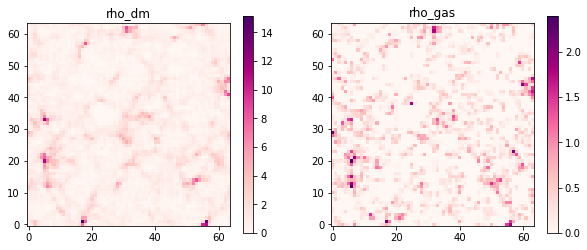

In [119]:
figure(figsize=(10,4))
subplot(121)
imshow(egd_rho_dm[:,:,100], origin='lower', cmap='RdPu')
colorbar()
title('rho_dm')

subplot(122)
imshow(egd_rho_gas[:,:,100], origin='lower', cmap='RdPu')
colorbar()
title('rho_gas')

In [120]:
def egd_correction(delta, pos, params):
    """
    Will compute the EGD displacement as a function of density traced by the 
    input particles.
    params contains [amplitude, scale, gamma]
    """
    kvec = fftk(nc)
    alpha, kl, gamma = params

    # Compute a temperature-like map from density contrast
    T = (delta+1)**gamma
    
    # Apply FFT to apply filtering
    T_k = jnp.fft.rfftn(T)
    filtered_T_k = gaussian_kernel(kvec, kl) * T_k # This applies a Gaussian smoothing

    # Compute derivatives of this filtered T-like field at the position of particles
    dpos_egd = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*filtered_T_k), pos) 
                      for i in range(3)],axis=-1)
    
    # Apply overal scaling of these displacements
    dpos_egd = - alpha * dpos_egd
   
    return dpos_egd

In [121]:
def gaussian_kernel(kvec, k_smooth):
  """
  Computes a gaussian kernel
  """
  kk = sum(ki**2 for ki in kvec)
  return jnp.exp(-0.5 * kk / k_smooth**2)

In [122]:
# this part will need to have an emulator etc.. on it
params_camels_optimized = np.array([0.93629056,2.0582693,0.46008348])
params_camels_optimized_extreme = np.array([100.93629056,100.0582693,0.46008348])

In [123]:
# Let's look at the result
# On the DMO side, we only grab the dark matter
total_particles_egd = cic_paint(egd_rho_dm, 
                            egd_pos_gas + egd_correction(total_delta_dmo, egd_pos_gas, params_camels_optimized))
total_mass_egd = total_particles_egd * Mpart
total_delta_egd = total_mass_egd/total_mass_egd.mean() - 1

<ipython-input-121-029dac6bc86f>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


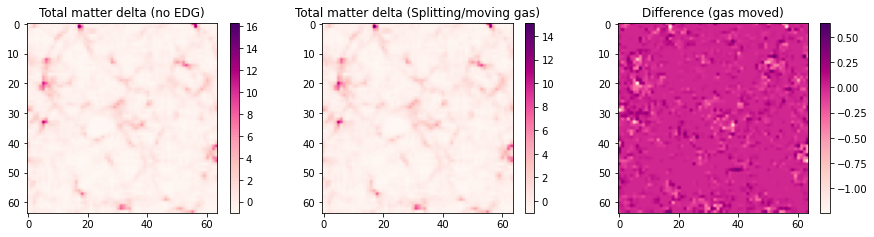

In [124]:
# First lets make a plot
figure(figsize=[15,3.5])
subplot(131)
imshow(total_delta_dmo[:,:,100], cmap='RdPu')
title('Total matter delta (no EDG)')
colorbar()
subplot(132)
imshow(total_delta_egd[:,:,100], cmap='RdPu')
title('Total matter delta (Splitting/moving gas)')
colorbar()
subplot(133)
imshow(total_delta_egd[:,:,100] - total_delta_dmo[:,:,100], cmap='RdPu')
title('Difference (gas moved)')
colorbar()

In [125]:
# # hard to see when stacked
# figure(figsize=[15,5])
# subplot(131)
# imshow(total_delta_dmo.sum(axis=2), cmap='RdPu')
# title('DMO')
# subplot(132)
# imshow(total_delta_egd.sum(axis=2), cmap='RdPu')
# title('DMO+EGD')
# subplot(133)
# imshow(total_delta_egd.sum(axis=2) - total_delta_dmo.sum(axis=2), cmap='RdPu')
# title('difference')

### Look at a more extreme example

In [126]:
# Let's look at the result
# On the DMO side, we only grab the dark matter
total_particles_egd = cic_paint(egd_rho_dm, 
                            egd_pos_gas + egd_correction(total_delta_dmo, egd_pos_gas, params_camels_optimized_extreme))
total_mass_egd = total_particles_egd * Mpart
total_delta_egd = total_mass_egd/total_mass_egd.mean() - 1

<ipython-input-121-029dac6bc86f>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum(ki**2 for ki in kvec)


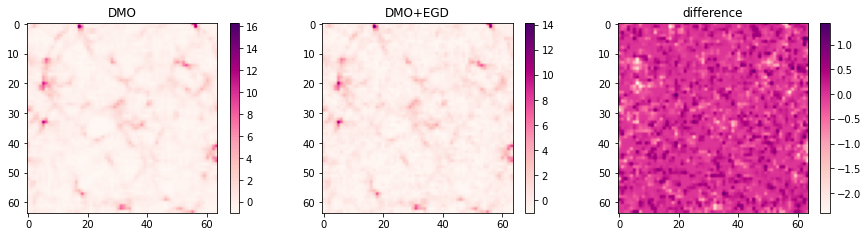

In [127]:
# First lets make a plot
figure(figsize=[15,3.5])
subplot(131)
imshow(total_delta_dmo[:,:,100], cmap='RdPu')
title('DMO')
colorbar()
subplot(132)
imshow(total_delta_egd[:,:,100], cmap='RdPu')
title('DMO+EGD')
colorbar()
subplot(133)
imshow(total_delta_egd[:,:,100] - total_delta_dmo[:,:,100], cmap='RdPu')
title('difference')
colorbar()

In [128]:
# scatter(res[0][XX][:,0], res[0][XX][:,1])

In [129]:
# H, edges = np.histogramdd(res[0][XX], range=((0,64),(0,64), (0,320)), bins = (64, 64, 1280))

In [130]:
# imshow(myrho[:,:,100], origin='lower', cmap='RdPu')
# colorbar()
# title('rho_m')

In [131]:
# hist(rho_m.flatten(), bins=100)
# title('rho_m at z~'+str(1./a_center[XX]-1))

In [132]:
from numpy.fft import fftn
import numpy.fft as nf

def create_kgrid(nx, ny, nz, lx, ly, lz):
    """
    Create a 3D k grid for Fourier space calculations
    """
    xres   = lx/nx #Mpc/h
    yres   = ly/ny #Mpc/h
    zres   = lz/nz #Mpc/h

    kx = nf.fftshift(np.fft.fftfreq(nx, xres))# h/Mpc
    ky = nf.fftshift(np.fft.fftfreq(ny, yres))# h/Mpc
    kz = nf.fftshift(np.fft.fftfreq(nz, zres))# h/Mpc
    
    mg = np.meshgrid(kx,ky,kz)

    #km = np.sqrt(np.sum((m**2 for m in mg)))
    km  = np.sqrt(mg[0]**2+mg[1]**2+mg[2]**2)
    #k2[nx/2,ny/2,nz/2]=1.
    print(np.min(km))
    return km

## Now add HPM table

use rho_total and fscalar_total - map to T and P

In [133]:
F_rhom = np.fft.fftshift(np.fft.fftn(total_mass_egd))

In [134]:
kg = create_kgrid(total_mass_egd.shape[0], total_mass_egd.shape[1], total_mass_egd.shape[2], lx=200, ly=200, lz=4000)
kg[np.where(kg==0)[0]]=np.inf

0.0


In [135]:
G = 6.67e-11             # m^3/kg/s^2
G = G*1.99e30            # m^3/Msun/s^2
G = G/(3.086e22)**2/1000 # (km)(Mpc^2)/Msun/s^2
G = G*3.15e16            # (km)(Mpc^2)/Msun/s/Gyr

#F_fscalar = 2*np.pi**2*G*F_rhom/kg*(1-np.exp(-kg**2*rssq))  *1.99e30/1000/(3.086e22)**2 * 3.1536e16 * 0.677 #(km/s)/Gyr
F_fscalar = 2*np.pi**2*G*F_rhom/kg # m^3/kg/s^2 (Msun/h)/(Mpc/h)^2  

R_fscalar = np.fft.ifftn(np.fft.ifftshift(F_fscalar)) 
# (m^3 Msun/h)/(kg*s^2 (Mpc/h)^2)) 
# (L^3 M)/(MT^2L^2)
# L/T^2

# 1 Gyr = 3.1536 × 10**16 s
# 1 Msun = 1.989e+30 kg
# 1 Mpc = 3.086e+19 km

# we want km/s/Gyr [L/T^2] -- in the paper

R_fscalar -= np.min(R_fscalar.real)  

# Lbox in Mpc/h

R_fscalar_new = R_fscalar * (10**(-3))**3 * (1.989* 10**30 / h)  * 3.1536 * 10**16 / (3.086*10**19/h)**2 

Text(0.5, 0, 'fscalar')

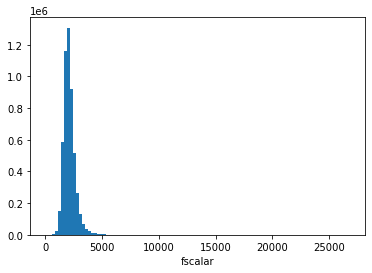

In [136]:
# hist(R_fscalar.flatten(), bins=100)
hist(R_fscalar_new.flatten(), bins=100)
xlabel('fscalar')

Text(0.5, 1.0, 'R_fscalar')

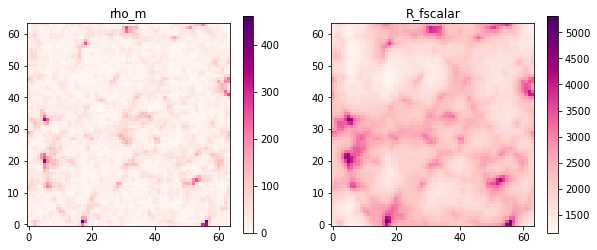

In [137]:
figure(figsize=(10,4))

subplot(121)
imshow(real(total_mass_egd[:,:,100]/rho_m_mean), origin='lower', cmap='RdPu')
colorbar()
title('rho_m')

subplot(122)
imshow(real(R_fscalar_new[:,:,100]), origin='lower', cmap='RdPu')
colorbar()
title('R_fscalar')

Text(0.5, 1.0, 'R_fscalar')

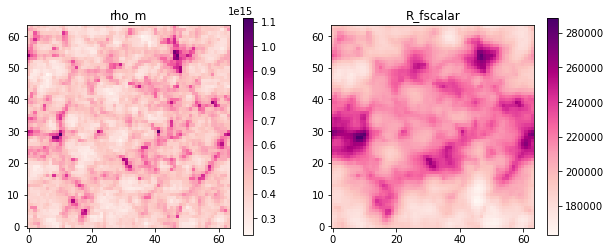

In [138]:
figure(figsize=(10,4))

subplot(121)
imshow(np.sum(real(total_mass_egd[:,:,:100]),axis=2), origin='lower', cmap='RdPu')
colorbar()
title('rho_m')

subplot(122)
imshow(np.sum(real(R_fscalar_new[:,:,:100]),axis=2), origin='lower', cmap='RdPu')
colorbar()
title('R_fscalar')


In [139]:
# # plot res as a function of redshift
# for i in range(39)[::5]:
#     H, edges = np.histogramdd(res[0][i], range=((0,64),(0,64), (0,1280)), bins = (64, 64, 1280))
#     rho_m = (H-np.mean(H.flatten()))*1.0/np.mean(H.flatten())
#     imshow(np.sum(real(rho_m[:,:,:100]),axis=2), vmin=-1, vmax=300, origin='lower', cmap='RdPu')
#     colorbar()
#     figure()

In [148]:
# Load hpm table
f  = open('hpm_table_z00.01.dat', 'rb')
dd = np.fromfile(f, dtype=np.int32,count=2);print(dd)
X  = np.fromfile(f, dtype=np.float32) 
Y  = X.reshape((dd[1],dd[0],14))

# Set up an interpolator
drho = Y[0,:,4]
psi  = Y[:,0,5]

Tt   = Y[:,:,8].astype(np.float64)  # [K]

'''
Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(3e8)**2                  # [(eV/c^2)*(m/s)^2/cm^3]
Pt   = Pt*1.783e-36                 # [(kg)*(m/s)^2/cm^3]
Pt   = Pt/1.99e30                   # [(Msun)*(m/s)^2/cm^3]
Pt   = Pt/(1000)**2                 # [(Msun)*(km/s)^2/cm^3]
Pt   = Pt*(3.086e24)**3             # [(Msun)*(km/s)^2/Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]
'''

Pt   = Y[:,:,10].astype(np.float64) # [keV/cm^3]
Pt   = Pt*1000                      # [eV/cm^3]
Pt   = Pt*(1.602e-19)               # [kg m^2/s^2 /cm^3]
Pt   = Pt/1.98847e30                # [Msun m^2/s^2 /cm^3]
Pt   = Pt/1000/1000                 # [Msun km^2/s^2 /cm^3]
Pt   = Pt*(3.086e24)**3             # [Msun km^2/s^2 /Mpc^3]
Pt   = Pt/h**2                      # [h^2(Msun)*(km/s)^2/Mpc^3]


#--------------> Pt is x10^10 high

from scipy.interpolate import RegularGridInterpolator
intpT = RegularGridInterpolator((psi,drho), Tt, bounds_error=False, fill_value=0)
intpP = RegularGridInterpolator((psi,drho), Pt, bounds_error=False, fill_value=0)

[145  70]


In [141]:
Tf = intpT( np.c_[(R_fscalar_new.real).flatten(), (total_mass_egd/np.mean(total_mass_egd)).flatten() ]).reshape((64,64,1280))
Pf = intpP( np.c_[(R_fscalar_new.real).flatten(), (total_mass_egd/np.mean(total_mass_egd)).flatten() ]).reshape((64,64,1280))

<ipython-input-142-5fdb4055bd61>:24: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(real(Tf[:,:,100])), origin='lower', cmap='RdPu')
<ipython-input-142-5fdb4055bd61>:29: RuntimeWarning: divide by zero encountered in log10
  imshow(np.log10(real(Pf[:,:,100])), origin='lower', cmap='RdPu')


Text(0.5, 1.0, 'log10(P)')

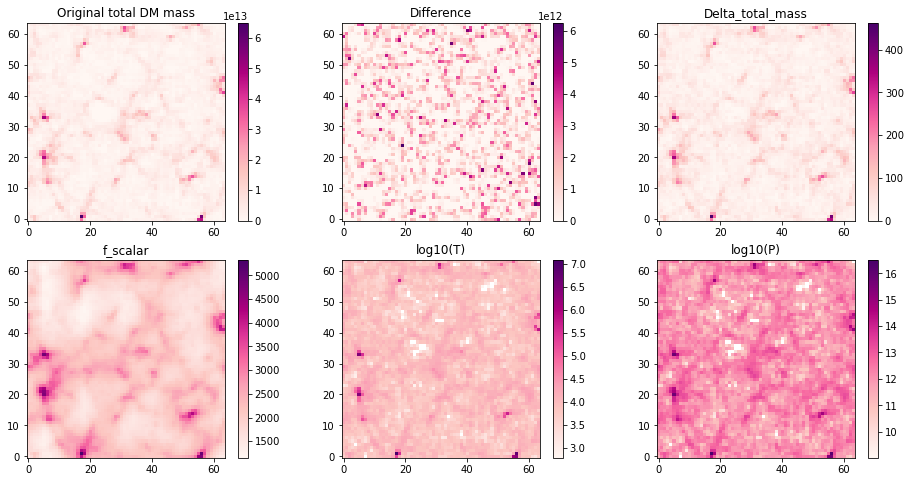

In [142]:
figure(figsize=(16,8))

subplot(231)
imshow(egd_rho_dm[:,:,100]*Mpart, origin='lower', cmap='RdPu')
colorbar()
title('Original total DM mass')

subplot(232)
imshow(total_mass_egd[:,:,100]-egd_rho_dm[:,:,100]*Mpart, origin='lower', cmap='RdPu')
colorbar()
title('Difference')

subplot(233)
imshow(total_mass_egd[:,:,100]/rho_m_mean, origin='lower', cmap='RdPu')
colorbar()
title('Delta_total_mass')

subplot(234)
imshow(real(R_fscalar_new[:,:,100]), origin='lower', cmap='RdPu')
colorbar()
title('f_scalar')

subplot(235)
imshow(np.log10(real(Tf[:,:,100])), origin='lower', cmap='RdPu')
colorbar()
title('log10(T)')

subplot(236)
imshow(np.log10(real(Pf[:,:,100])), origin='lower', cmap='RdPu')
colorbar()
title('log10(P)')

Text(0.5, 1.0, 'log10(P)')

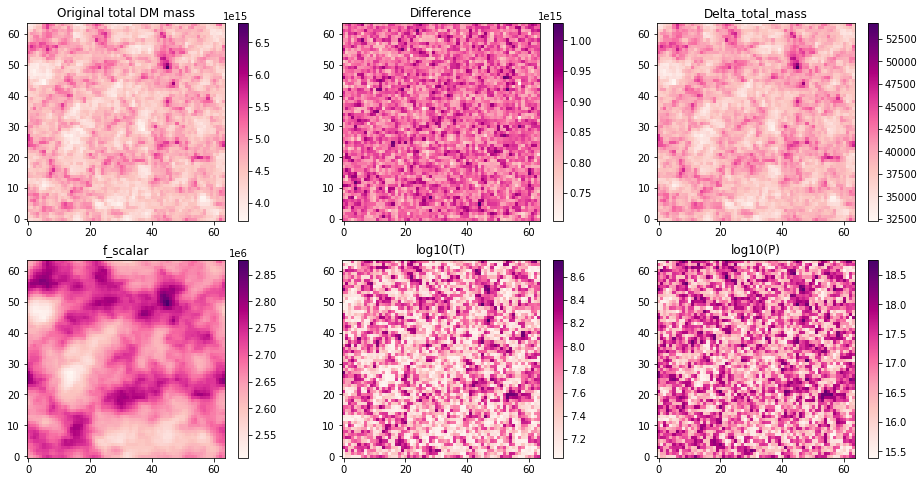

In [143]:
# now stack the whole cube
figure(figsize=(16,8))

subplot(231)
imshow(egd_rho_dm.sum(axis=2)*Mpart, origin='lower', cmap='RdPu')
colorbar()
title('Original total DM mass')

subplot(232)
imshow(total_mass_egd.sum(axis=2)-egd_rho_dm.sum(axis=2)*Mpart, origin='lower', cmap='RdPu')
colorbar()
title('Difference')

subplot(233)
imshow(total_mass_egd.sum(axis=2)/rho_m_mean, origin='lower', cmap='RdPu')
colorbar()
title('Delta_total_mass')

subplot(234)
imshow(real(R_fscalar_new.sum(axis=2)), origin='lower', cmap='RdPu')
colorbar()
title('f_scalar')

subplot(235)
imshow(np.log10(real(Tf.sum(axis=2))), origin='lower', cmap='RdPu')
colorbar()
title('log10(T)')

subplot(236)
imshow(np.log10(real(Pf.sum(axis=2))), origin='lower', cmap='RdPu')
colorbar()
title('log10(P)')

## Note to self, units very much will need checking!

In [ ]:
## compton-Y and lensing